# PS4: Quantitative Macroeconomics
## Jorge Batanero 

## A Simple Wealth Model

In [92]:
# Import packages

import numpy as np
from numpy import vectorize
from itertools import product
import matplotlib.pyplot as plt
import scipy as sp
from scipy.interpolate import BSpline
from scipy.interpolate import interp1d

**Recursive Formulation of the Wealth Model**


The recursive formulation of the simple wealth economy is given by, 


(1)  $V(a,y) = \underset{\bar A \leq a' \leq (1+r)a+yw}{\max{}} u(wy + (1+r)a - a') + \beta \sum_{y'} \pi(y'|y) V'(a',y') $

Which can be written as follows:

  $V(a,y) = \underset{\bar A \leq a' \leq (1+r)a+yw}{\max{}} u(wy + (1+r)a - a')-\lambda_a(a'+\bar{A}) + \beta \sum_{y'} \pi(y'|y) V'(a',y')$

FOC:

(2) $\frac{\partial V(a,y)}{\partial a'}=0 \to -u_c(wy + (1+r)a - a')-\lambda_a+\beta \sum_{y'}\pi_{y'|y} \frac{\partial V(a',y')}{\partial a'}=0 $

We need to extra conditions:

- Complementary slackness $\lambda_a(a'+\bar{A})=0$

- Dual feasibility $\lambda_a \ge 0$

Now we apply the envelope theorem. The envelope theorem tells us that the derivative of the value function with respect to a
state variable is the derivative of the utility with respect to that state variable. To arrive at
this result, derive $\frac{\partial V(a,y)}{\partial a}$ where you substitute out for the policy functions $g^a(.)$ which depend
on a. So we can write the problem as follows:

$V(a,y) = \underset{\bar A \leq a' \leq (1+r)a+yw}{\max{}} u(wy + (1+r)a - g^a(a,y))-\lambda_a(g^a(a,y)+\bar{A}) + \beta \sum_{y'} \pi(y'|y) V'(g^a(a,y),y')$

Now taking the derivative with respect to a.
\begin{align}
\frac{\partial V(a,y)}{\partial a}=u_c(wy+(1+r)a-g^a(a,y))(1+r)-u_c(wy+(1+r)a-g^a(a,y))\frac{\partial g^a(a,y)}{\partial a}-\lambda_a\frac{\partial g^a(a,y)}{\partial a}+\beta \sum_{y'}\pi_{y'|y}\frac{V(g^a(a,y))}{\partial g^a(a,y)}\frac{\partial g^a(a,y)}{\partial a}
\end{align}

Therefore given that the policy function is at the maximum, all derivatives $\frac{\partial g^a(a,y)}{\partial a}=0$. Therefore for each period we get $\frac{\partial V(a,y)}{\partial a}=u_c(c)(1+r)$. Substituting in the first order condition we get:

(3) $ u_c(c)=-\lambda_a+\beta(1+r) \sum_{y'}\pi_{y'|y} u_c(c') $

Therefore, 
$
U_c(c)  \left\{ \begin{array}{ll}
\geq \frac{1+r}{1+\rho}\sum_{y'}\pi_{y'|y} u_c(c')) & \textrm{if $a' = \bar{A}$}\\
= \frac{1+r}{1+\rho}  \sum_{y'}\pi_{y'|y} u_c(c')) & \textrm{if $a' \geq \bar{A}$}
\end{array} \right.
$

Where $\bar{A}=0$ if borrowing is not allowed and $\bar{A}=y_{min} \frac {r+1}{r}$ if borrowing is allowed.





In [93]:
# Parametrization of the model:

ρ= 0.06
β = 1/(1+ρ)
w = 1
r = 0.04
γ = 0.5
σ_y = 0.2
ε=0.001 # tolerance

# Transition matrix for the Markov Process
π = np.array([((1+γ)/2, (1-γ)/2),((1-γ)/2, (1+γ)/2)])

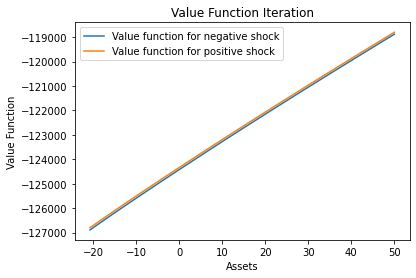

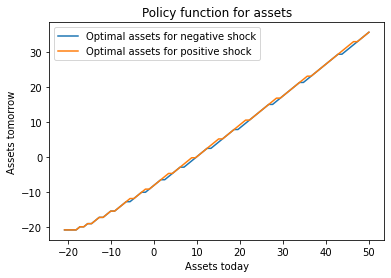

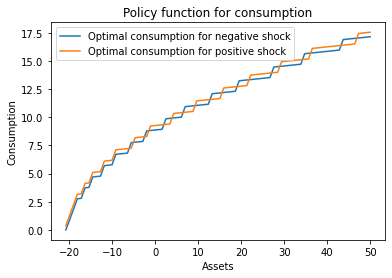

In [94]:
#The infinitely-lived households economy 

#Quadratic Utility

Y = (1-σ_y, 1+σ_y)
# parameter for avoiding saturation of any consumer
c_bar = 100*Y[1]     
# Create a grid over assets tomorrow
# Here replacing (1+r)/r for 0 we can solve the model when borrowing is not allowed
A = np.linspace(((-(1+r)/r)*Y[0]), 50, 80)   

a_y = list(product(Y, A, A))
a_y = np.array(a_y)

y = a_y[:, 0]
a_i = a_y[:, 1]
a_j = a_y[:, 2]

c = y+(1+r)*a_i-a_j

@vectorize
    
def Utility(c):
    
    return -0.5*(c-c_bar)**2
     
Utility = Utility(c)
Utility = np.reshape(Utility, (1, 12800))
Utility = np.reshape(Utility, (160, 80))

# Initial guess for the value function is a vector of zeros:
V_guess = np.zeros(160)

# Compute the matrix W:
def W1(A):   
    
    return π[0, 0]*(-0.5*(Y[0] + (1+r)*A - A - c_bar)**2)/(1-β) + π[0, 1]*(-0.5*(Y[1] + (1+r)*A - A - c_bar)**2)/(1-β)

def W2(A):
    
    return π[1, 0]*(-0.5*(Y[0] + (1+r)*A - A - c_bar)**2)/(1-β) + π[1, 1]*(-0.5*(Y[1] + (1+r)*A - A - c_bar)**2)/(1-β)

        
W1 = W1(A)
W1 = np.reshape(W1, (80,1))
W1 = np.tile(W1, 80)
W1 = np.transpose(W1)

W2 = W2(A)
W2 = np.reshape(W2, (80,1))
W2 = np.tile(W2, 80)
W2 = np.transpose(W2)

W = [W1, W2]
W = np.reshape(W, (160,80))

# Compute the matrix X:
X = Utility + β*W

V_next = np.amax(X, axis = 1)

diff_V = V_guess - V_next

count = 0

# We iterate until the difference is smaller than ε
while np.any(abs(diff_V)>ε):
    
    Vss = V_next
    V_guess = [Vss[0:80], Vss[80:]]
    V_guess = np.array(V_guess)
    
    def W1(V_guess):
        
        return π[0, 0]*V_guess[0, :] + π[0, 1]*V_guess[1, :]
    
    def W2(V_guess):
        
        return π[1, 0]*V_guess[0, :] + π[1, 1]*V_guess[1, :]

    W1 = W1(V_guess)
    W1 = np.reshape(W1, (1,80))
    W1 = np.tile(W1, 80)
    W1 = np.reshape(W1, (80,80))

    W2 = W2(V_guess)
    W2 = np.reshape(W2, (1,80))
    W2 = np.tile(W2, 80)
    W2 = np.reshape(W2, (80,80))
    
    W = [W1, W2]
    W = np.reshape(W, (160, 80))
    
    X = Utility + β*W
    
    V_next = np.amax(X, axis = 1)
    
    diff_V = Vss - V_next
    
    count += 1
    

# Once we obtain convergence, redefine the matrix X:
X = Utility + β*W

# The value function for each possible state of the economy
V_y_low = V_next[0:80]
V_y_high = V_next[80:]

# Now we can obtain the policy function
g = np.argmax(X, axis = 1)

# For the first 45 periods:
a_optimal_y_low = A[g[0:80]]     # optimal decision of assets given y_low
a_optimal_y_high = A[g[80:]]    # optimal decision of assets given y_high

c_y_low = Y[0]*np.ones(80) + (1+r)*A - a_optimal_y_low

c_y_high = Y[1]*np.ones(80) + (1+r)*A - a_optimal_y_high

for i in range(0, 80):
    
    if c_y_low[i] < 0:
        
        c_y_low[i] = 0
        
    if c_y_high[i] < 0:
        
        c_y_high[i] = 0
           
# Plot the value function and the optimal policy:
    
plt.figure()
plt.plot(A, V_y_low, label = 'Value function for negative shock')
plt.plot(A, V_y_high, label = 'Value function for positive shock')
plt.title('Value Function Iteration')
plt.legend()
plt.ylabel('Value Function')
plt.xlabel('Assets')
plt.show()
    
plt.figure()
plt.plot(A, a_optimal_y_low, label = 'Optimal assets for negative shock')
plt.plot(A, a_optimal_y_high, label = 'Optimal assets for positive shock')
plt.title('Policy function for assets')
plt.legend()
plt.ylabel('Assets tomorrow')
plt.xlabel('Assets today')
plt.show()

plt.figure()
plt.plot(A, c_y_low, label = 'Optimal consumption for negative shock')
plt.plot(A, c_y_high, label = 'Optimal consumption for positive shock')
plt.title('Policy function for consumption')
plt.legend()
plt.ylabel('Consumption')
plt.xlabel('Assets')
plt.show()


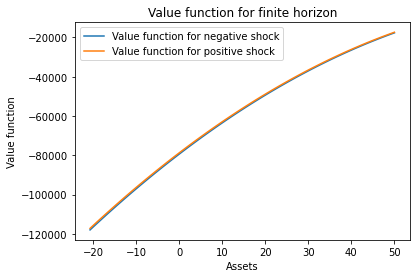

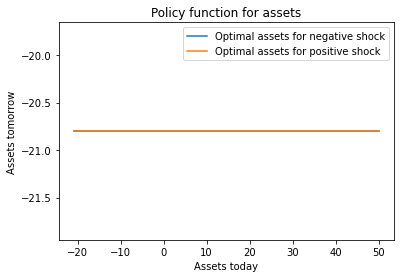

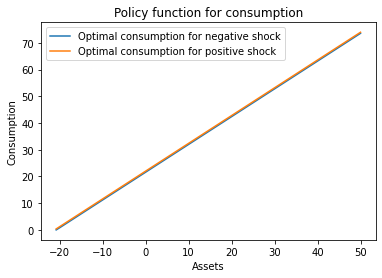

In [95]:
# The life-cycle economy (Backwards)

#Quadratic Utility 
W = np.zeros((160, 80))

count = 0

while count < 45:
    
    W = np.amax((Utility + β*W), axis = 1)
    W = np.reshape(W,(160, 1))
    W = W*np.ones((160, 80))
    
    count += 1

plt.plot(A, W[0:80, 0], label = 'Value function for negative shock')
plt.plot(A, W[80:, 0], label = 'Value function for positive shock')
plt.legend()
plt.title('Value function for finite horizon')
plt.ylabel('Value function')
plt.xlabel('Assets')
plt.show()

X = Utility + β*W
g = np.argmax(X, axis = 1)

a_optimal_y_low = A[g[0:80]]     # optimal decision of assets given y_low
a_optimal_y_high = A[g[80:]]      # optimal decision of assets given y_high

c_y_low = Y[0]*np.ones(80) + (1+r)*A - a_optimal_y_low

c_y_high = Y[1]*np.ones(80) + (1+r)*A - a_optimal_y_high

for i in range(0, 80):
    
    if c_y_low[i] < 0:
        
        c_y_low[i] = 0
        
    if c_y_high[i] < 0:
        
        c_y_high[i] = 0
        
plt.figure()
plt.plot(A, a_optimal_y_low, label = 'Optimal assets for negative shock')
plt.plot(A, a_optimal_y_high, label = 'Optimal assets for positive shock')
plt.legend()
plt.title('Policy function for assets')
plt.ylabel('Assets tomorrow')
plt.xlabel('Assets today')
plt.show()

plt.figure()
plt.plot(A, c_y_low, label = 'Optimal consumption for negative shock')
plt.plot(A, c_y_high, label = 'Optimal consumption for positive shock')
plt.title('Policy function for consumption')
plt.legend()
plt.ylabel('Consumption')
plt.xlabel('Assets')
plt.show()


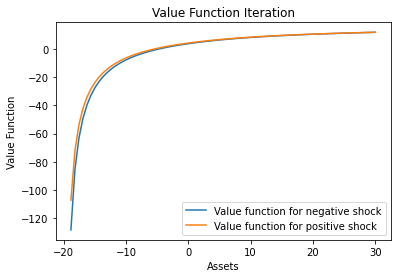

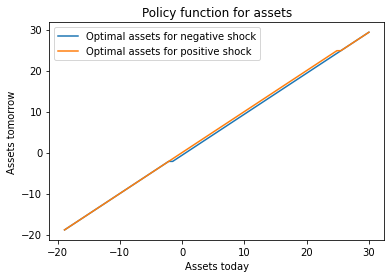

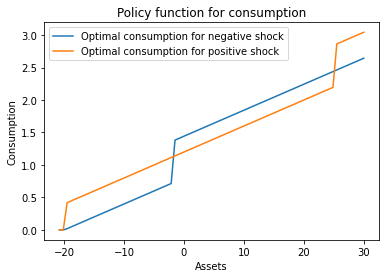

In [96]:
# The infinitely-lived households economy (Discrete method)

# CRRA Utility 

σ = 2
# Create a grid over assets tomorrow
# Here replacing (1+r)/r for 0 we can solve the model when borrowing is not allowed
A = np.linspace(((-(1+r)/r)*Y[0]), 30, 80)    

a_y = list(product(Y, A, A))
a_y = np.array(ay)

y = a_y[:, 0]
a_i = a_y[:, 1]
a_j = a_y[:, 2]

c = y + (1+r)*a_i - a_j
        
Utility = np.zeros(12800)

for i in range(0, 12800):
    
    if c[i] >= 0:
        
        Utility[i] = ((c[i]**(1-σ))-1)/(1-σ)
        
    if c[i] < 0:
        
        Utility[i] = -100000

Utility = np.reshape(Utility, (1, 12800))        
Utility = np.reshape(Utility, (160, 80))

# Initial guess for the value function is a vector of zeros:
V_guess = np.zeros(160)

# Compute the matrix W:
def W1(A):   
    
    return π[0, 0]*(((Y[0] + (1+r)*A - A)**(1-σ))-1)/((1-σ)*(1-β)) + π[0, 1]*(((Y[1] + (1+r)*A - A)**(1-σ))-1)/((1-σ)*(1-β))

def W2(A):
    
    return π[1, 0]*(((Y[0] + (1+r)*A - A)**(1-σ))-1)/((1-σ)*(1-β)) + π[1, 1]*(((Y[1] + (1+r)*A - A)**(1-σ))-1)/((1-σ)*(1-β))

        
W1 = W1(A)
W1 = np.reshape(W1, (80,1))
W1 = np.tile(W1, 80)
W1 = np.transpose(W1)

W2 = W2(A)
W2 = np.reshape(W2, (80,1))
W2 = np.tile(W2, 80)
W2 = np.transpose(W2)

W = [W1, W2]
W = np.reshape(W, (160,80))

# Compute the matrix X:
X = Utility + β*W

V_next = np.amax(X, axis = 1)

diff_V = V_guess - V_next

count = 0

# We iterate until the difference is smaller than ε
while np.any(abs(diff_V)>ε):
    
    Vss = V_next
    V_guess = [Vss[0:80], Vss[80:]]
    V_guess = np.array(V_guess)
    
    def W1(V_guess):
        
        return π[0, 0]*V_guess[0, :] + π[0, 1]*V_guess[1, :]
    
    def W2(V_guess):
        
        return π[1, 0]*V_guess[0, :] + π[1, 1]*V_guess[1, :]

    W1 = W1(V_guess)
    W1 = np.reshape(W1, (1,80))
    W1 = np.tile(W1, 80)
    W1 = np.reshape(W1, (80,80))

    W2 = W2(V_guess)
    W2 = np.reshape(W2, (1,80))
    W2 = np.tile(W2, 80)
    W2 = np.reshape(W2, (80,80))
    
    W = [W1, W2]
    W = np.reshape(W, (160, 80))
    
    X = Utility + β*W
    
    V_next = np.amax(X, axis = 1)
    
    diff_V = Vss - V_next
    
    count += 1
    

# Once we obtain convergence, redefine the matrix X:
X = Utility + β*W

# The value function for each possible state of the economy
V_y_low = V_next[0:80]
V_y_high = V_next[80:]

# Now we can obtain the policy function
g = np.argmax(X, axis = 1)

# For the first 45 periods:
a_optimal_y_low = A[g[0:80]]     # optimal decision of assets given y_low
a_optimal_y_high = A[g[80:]]    # optimal decision of assets given y_high

for i in range(0, 2):
    
    a_optimal_y_low[i] = 0
    a_optimal_y_high[i] = 0
    

c_y_low = Y[0]*np.ones(80) + (1+r)*A - a_optimal_y_low

c_y_high = Y[1]*np.ones(80) + (1+r)*A - a_optimal_y_high

for i in range(0, 80):
    
    if c_y_low[i] < 0:
        
        c_y_low[i] = 0
        
    if c_y_high[i] < 0:
        
        c_y_high[i] = 0
           
# Plot the value function and the policy function:  
plt.figure()
plt.plot(A[3:], V_y_low[3:], label = 'Value function for negative shock')
plt.plot(A[3:], V_y_high[3:], label = 'Value function for positive shock')
plt.title('Value Function Iteration')
plt.legend()
plt.ylabel('Value Function')
plt.xlabel('Assets')
plt.show()
    
plt.figure()
plt.plot(A[3:], a_optimal_y_low[3:], label = 'Optimal assets for negative shock')
plt.plot(A[3:], a_optimal_y_high[3:], label = 'Optimal assets for positive shock')
plt.title('Policy function for assets')
plt.legend()
plt.ylabel('Assets tomorrow')
plt.xlabel('Assets today')
plt.show()

plt.figure()
plt.plot(A, c_y_low, label = 'Optimal consumption for negative shock')
plt.plot(A, c_y_high, label = 'Optimal consumption for positive shock')
plt.title('Policy function for consumption')
plt.legend()
plt.ylabel('Consumption')
plt.xlabel('Assets')
plt.show()

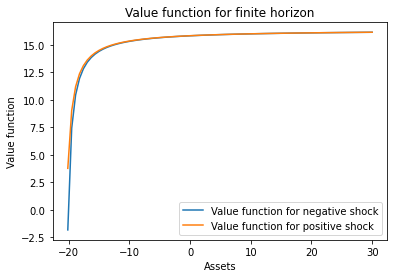

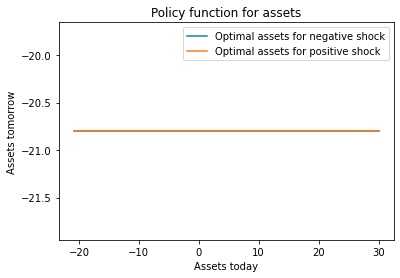

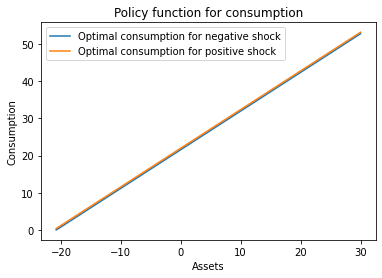

In [97]:
# The life-cycle economy (Backwards)

# CRRA Utility 

W = np.zeros((160, 80))

count = 0

while count < 45:
    
    W = np.amax((Utility + β*W), axis = 1)
    W = np.reshape(W,(160, 1))
    W = W*np.ones((160, 80))
    
    count += 1

plt.plot(A[1:], W[1:80, 1], label = 'Value function for negative shock')
plt.plot(A[1:], W[81:, 1], label = 'Value function for positive shock')
plt.title('Value function for finite horizon')
plt.legend()
plt.ylabel('Value function')
plt.xlabel('Assets')
plt.show()

X = Utility + β*W
g = np.argmax(X, axis = 1)

a_optimal_y_low = A[g[0:80]]     # optimal decision of assets given y_low
a_optimal_y_high = A[g[80:]]      # optimal decision of assets given y_high

c_y_low = Y[0]*np.ones(80) + (1+r)*A - a_optimal_y_low

c_y_high = Y[1]*np.ones(80) + (1+r)*A - a_optimal_y_high

for i in range(0, 80):
    
    if c_y_low[i] < 0:
        
        c_y_low[i] = 0
        
    if c_y_high[i] < 0:
        
        c_y_high[i] = 0
        
plt.figure()
plt.plot(A, a_optimal_y_low, label = 'Optimal assets for negative shock')
plt.plot(A, a_optimal_y_high, label = 'Optimal assets for positive shock')
plt.title('Policy function for assets')
plt.legend()
plt.ylabel('Assets tomorrow')
plt.xlabel('Assets today')
plt.show()

plt.figure()
plt.plot(A, c_y_low, label = 'Optimal consumption for negative shock')
plt.plot(A, c_y_high, label = 'Optimal consumption for positive shock')
plt.title('Policy function for consumption')
plt.legend()
plt.ylabel('Consumption')
plt.xlabel('Assets')
plt.show()

